In [1]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np
from math import log

In [2]:
START_DATE = datetime.date(2020,2,24)

In [3]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str = day.strftime("%Y%m%d")
        filename = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df = pd.read_csv(filename)
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day = day + datetime.timedelta(days = 1)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()

    plt.show()
    return

In [4]:
def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str = day.strftime("%Y%m%d")
        filename = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df = pd.read_csv(filename)
        cases[day_str] = int(df[(df["denominazione_regione"]==region)&(df["denominazione_provincia"]!='In fase di definizione/aggiornamento')]["totale_casi"].sum())
        day = day + datetime.timedelta(days = 1)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [5]:
def calculate_and_create_chart_for_Italy(start_date: datetime.date):
    day = start_date
    cases = {}
    while day<=datetime.date.today():
        day_str = day.strftime("%Y%m%d")
        filename = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df = pd.read_csv(filename)
        cases[day_str] = int(df[df["denominazione_provincia"]!='In fase di definizione/aggiornamento']["totale_casi"].sum())
        day = day + datetime.timedelta(days = 1)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()

    plt.show()
    return

In [6]:
def calculate_stats(cases_df):
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    cases_df_yesterday = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 1)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_five_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 5)).strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases up to today:", cases_df_today)
    print("New cases registered today:", cases_df_today-cases_df_yesterday)
    print("Doubling time in the last five days:", round(calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago), 1))
    print("Trend of new cases (in %) in the last 5 days:", round((cases_df_today-cases_df_five_days_ago)/cases_df_five_days_ago*100,2))
    return

In [7]:
def calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago):
    return (5*log(2))/(log(cases_df_today/cases_df_five_days_ago))
    

# Casi di COVID-19 in Italia - COVID-19 cases in Italy

Total cases up to today: 62030
New cases registered today: 4518
Doubling time in the last five days: 6.0
Trend of new cases (in %) in the last 5 days: 78.3


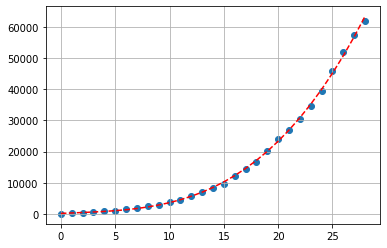

In [8]:
calculate_and_create_chart_for_Italy(START_DATE)

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

Total cases up to today: 663
New cases registered today: 76
Doubling time in the last five days: 3.7
Trend of new cases (in %) in the last 5 days: 152.09


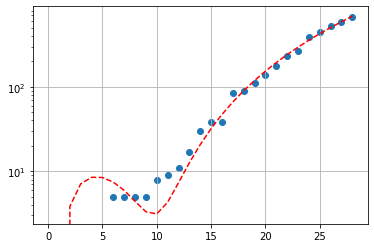

In [9]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

Total cases up to today: 129
New cases registered today: 27
Doubling time in the last five days: 3.2
Trend of new cases (in %) in the last 5 days: 193.18


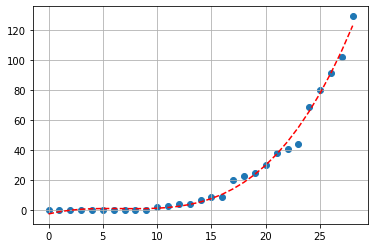

In [10]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

## L'Aquila

Total cases up to today: 40
New cases registered today: 2
Doubling time in the last five days: 5.0
Trend of new cases (in %) in the last 5 days: 100.0


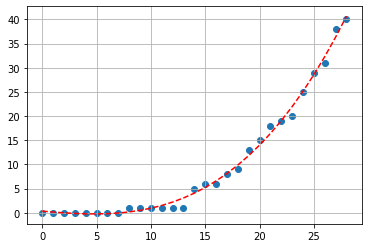

In [11]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

## Pescara

Total cases up to today: 370
New cases registered today: 36
Doubling time in the last five days: 4.1
Trend of new cases (in %) in the last 5 days: 131.25


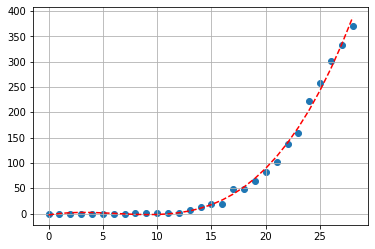

In [12]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

## Teramo

Total cases up to today: 124
New cases registered today: 11
Doubling time in the last five days: 3.0
Trend of new cases (in %) in the last 5 days: 217.95


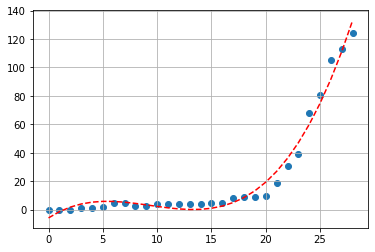

In [13]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

Total cases up to today: 90
New cases registered today: 9
Doubling time in the last five days: 2.9
Trend of new cases (in %) in the last 5 days: 233.33


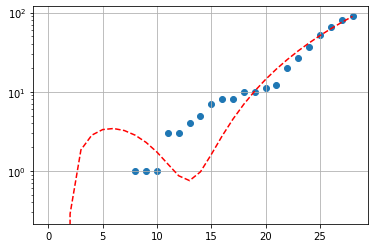

In [14]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

Total cases up to today: 18
New cases registered today: 2
Doubling time in the last five days: 2.7
Trend of new cases (in %) in the last 5 days: 260.0


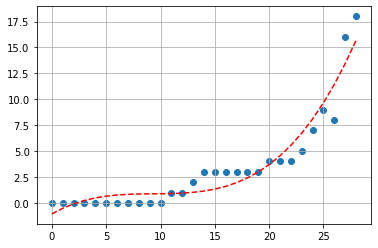

In [15]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

Total cases up to today: 72
New cases registered today: 7
Doubling time in the last five days: 2.9
Trend of new cases (in %) in the last 5 days: 227.27


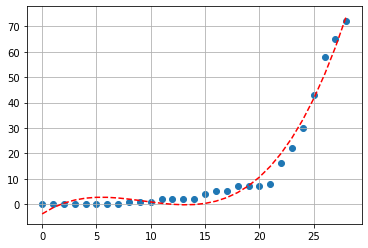

In [16]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

Total cases up to today: 724
New cases registered today: 46
Doubling time in the last five days: 5.3
Trend of new cases (in %) in the last 5 days: 92.55


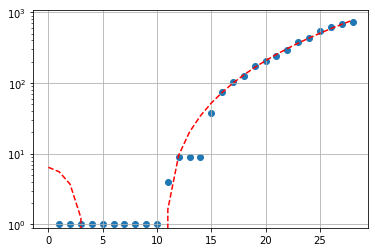

In [17]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

Total cases up to today: 290
New cases registered today: 19
Doubling time in the last five days: 4.3
Trend of new cases (in %) in the last 5 days: 124.81


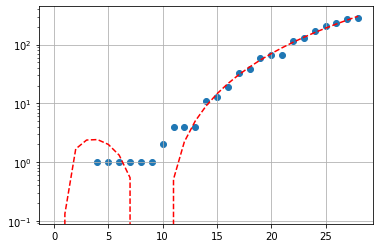

In [18]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

Total cases up to today: 46
New cases registered today: 1
Doubling time in the last five days: 4.2
Trend of new cases (in %) in the last 5 days: 130.0


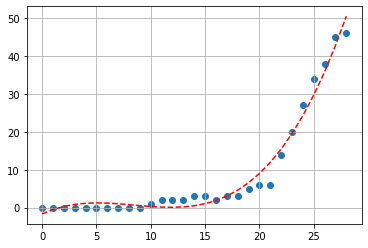

In [19]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

Total cases up to today: 68
New cases registered today: 5
Doubling time in the last five days: 4.4
Trend of new cases (in %) in the last 5 days: 119.35


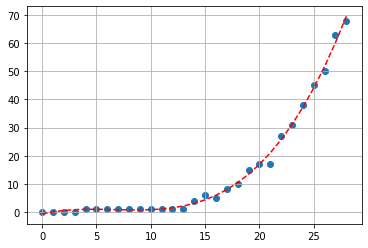

In [20]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

Total cases up to today: 62
New cases registered today: 1
Doubling time in the last five days: 3.5
Trend of new cases (in %) in the last 5 days: 169.57


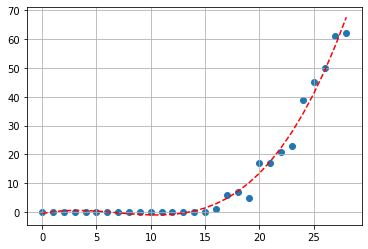

In [21]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

Total cases up to today: 94
New cases registered today: 6
Doubling time in the last five days: 5.0
Trend of new cases (in %) in the last 5 days: 100.0


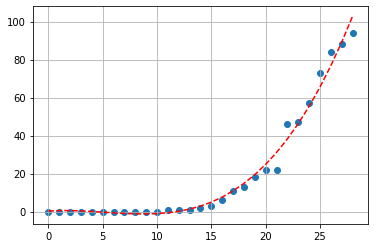

In [22]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

Total cases up to today: 20
New cases registered today: 6
Doubling time in the last five days: 3.8
Trend of new cases (in %) in the last 5 days: 150.0


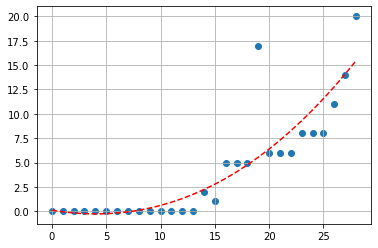

In [23]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

Total cases up to today: 1004
New cases registered today: 82
Doubling time in the last five days: 4.3
Trend of new cases (in %) in the last 5 days: 124.11


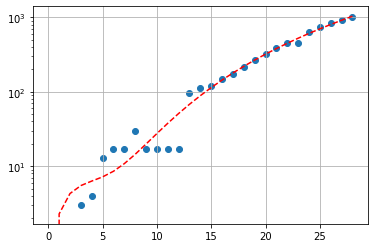

In [24]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

Total cases up to today: 145
New cases registered today: 13
Doubling time in the last five days: 3.6
Trend of new cases (in %) in the last 5 days: 158.93


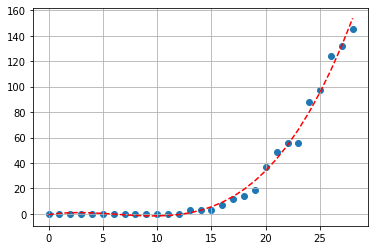

In [25]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

Total cases up to today: 13
New cases registered today: 0
Doubling time in the last five days: 2.9
Trend of new cases (in %) in the last 5 days: 225.0


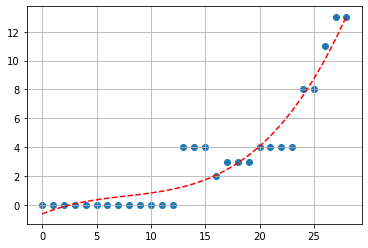

In [26]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

Total cases up to today: 124
New cases registered today: 8
Doubling time in the last five days: 5.4
Trend of new cases (in %) in the last 5 days: 90.77


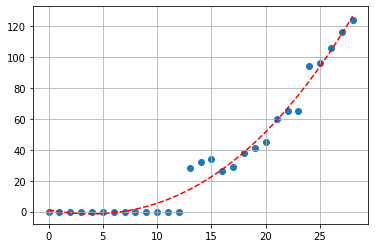

In [27]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

Total cases up to today: 543
New cases registered today: 39
Doubling time in the last five days: 4.7
Trend of new cases (in %) in the last 5 days: 110.47


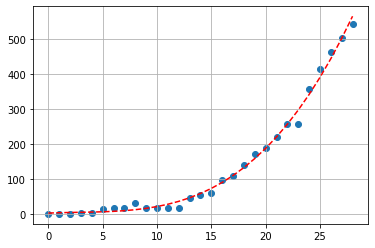

In [28]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

Total cases up to today: 179
New cases registered today: 22
Doubling time in the last five days: 3.4
Trend of new cases (in %) in the last 5 days: 175.38


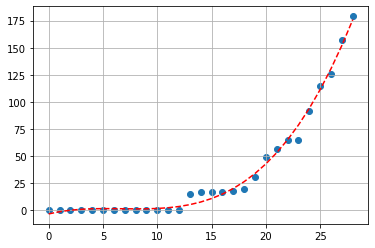

In [29]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

Total cases up to today: 8535
New cases registered today: 980
Doubling time in the last five days: 5.5
Trend of new cases (in %) in the last 5 days: 88.62


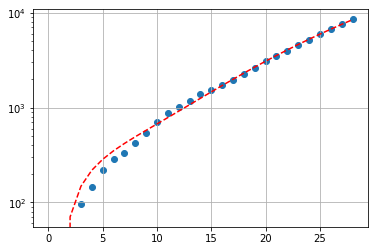

In [30]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

Total cases up to today: 833
New cases registered today: 159
Doubling time in the last five days: 4.6
Trend of new cases (in %) in the last 5 days: 110.89


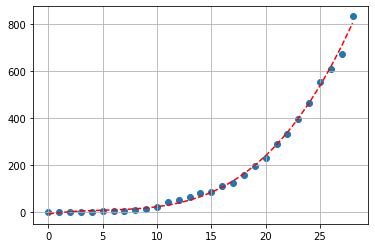

In [31]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

Total cases up to today: 172
New cases registered today: 22
Doubling time in the last five days: 3.5
Trend of new cases (in %) in the last 5 days: 168.75


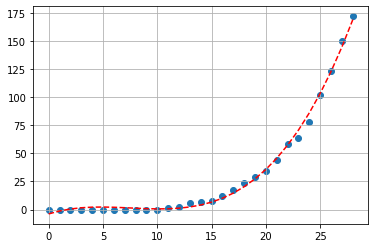

In [32]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Forlì-Cesena

Total cases up to today: 380
New cases registered today: 51
Doubling time in the last five days: 4.3
Trend of new cases (in %) in the last 5 days: 122.22


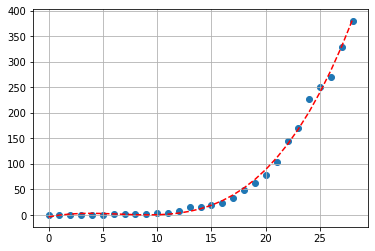

In [33]:
calculate_and_create_chart_for_province(START_DATE, 'Forlì-Cesena')

## Modena

Total cases up to today: 1155
New cases registered today: 145
Doubling time in the last five days: 5.0
Trend of new cases (in %) in the last 5 days: 100.87


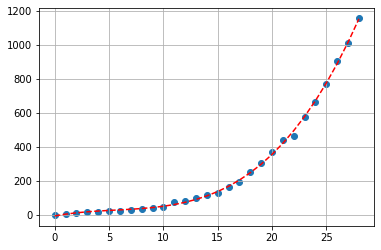

In [34]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

Total cases up to today: 1364
New cases registered today: 155
Doubling time in the last five days: 6.5
Trend of new cases (in %) in the last 5 days: 70.5


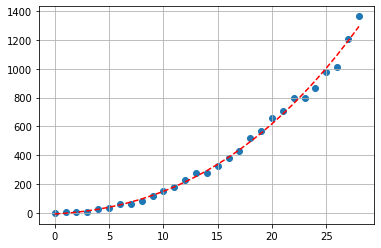

In [35]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

Total cases up to today: 1885
New cases registered today: 120
Doubling time in the last five days: 10.2
Trend of new cases (in %) in the last 5 days: 40.67


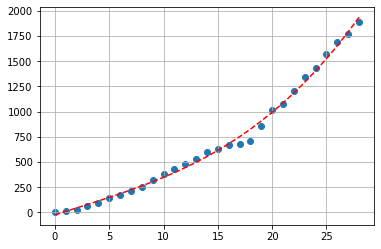

In [36]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

Total cases up to today: 342
New cases registered today: 33
Doubling time in the last five days: 4.3
Trend of new cases (in %) in the last 5 days: 123.53


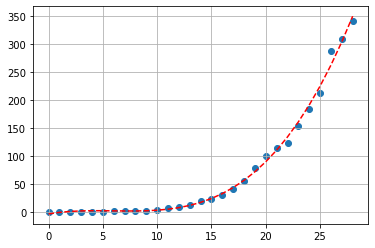

In [37]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

Total cases up to today: 1369
New cases registered today: 202
Doubling time in the last five days: 2.9
Trend of new cases (in %) in the last 5 days: 230.68


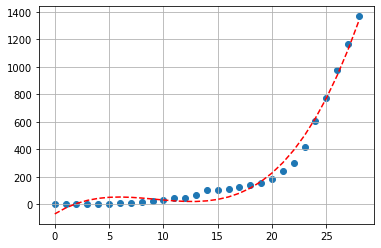

In [38]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

Total cases up to today: 1035
New cases registered today: 93
Doubling time in the last five days: 6.6
Trend of new cases (in %) in the last 5 days: 68.84


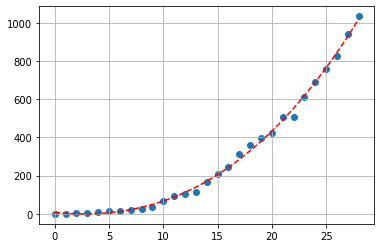

In [39]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

Total cases up to today: 930
New cases registered today: 63
Doubling time in the last five days: 5.0
Trend of new cases (in %) in the last 5 days: 101.3


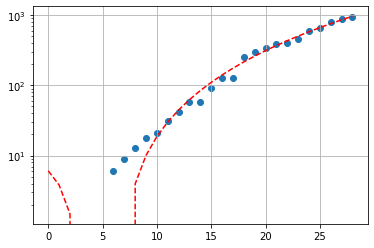

In [40]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

Total cases up to today: 55
New cases registered today: 11
Doubling time in the last five days: 4.4
Trend of new cases (in %) in the last 5 days: 120.0


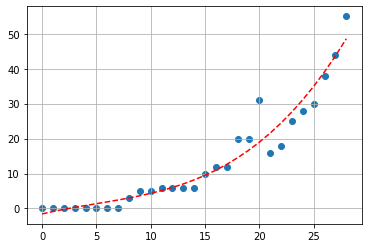

In [41]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

Total cases up to today: 170
New cases registered today: 5
Doubling time in the last five days: 4.3
Trend of new cases (in %) in the last 5 days: 123.68


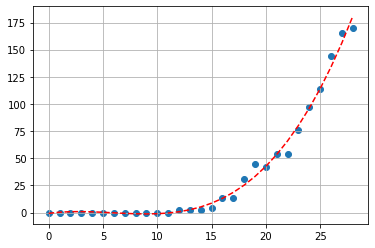

In [42]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

Total cases up to today: 320
New cases registered today: 23
Doubling time in the last five days: 6.0
Trend of new cases (in %) in the last 5 days: 77.78


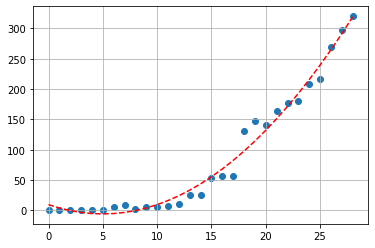

In [43]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

Total cases up to today: 385
New cases registered today: 24
Doubling time in the last five days: 4.6
Trend of new cases (in %) in the last 5 days: 112.71


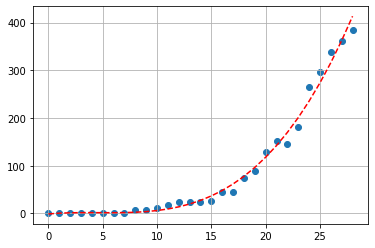

In [44]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

Total cases up to today: 1536
New cases registered today: 157
Doubling time in the last five days: 4.6
Trend of new cases (in %) in the last 5 days: 113.93


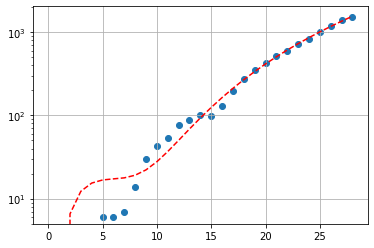

In [45]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

Total cases up to today: 82
New cases registered today: 4
Doubling time in the last five days: 8.3
Trend of new cases (in %) in the last 5 days: 51.85


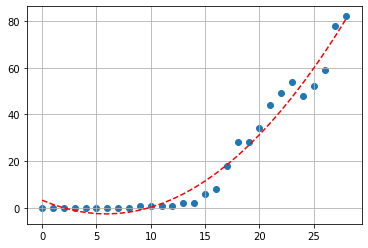

In [46]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

Total cases up to today: 159
New cases registered today: 13
Doubling time in the last five days: 1.8
Trend of new cases (in %) in the last 5 days: 591.3


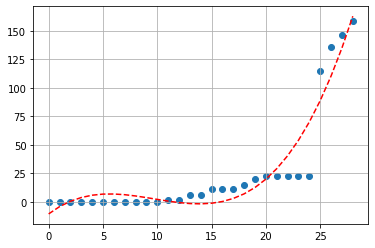

In [47]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

Total cases up to today: 31
New cases registered today: 7
Doubling time in the last five days: 3.7
Trend of new cases (in %) in the last 5 days: 158.33


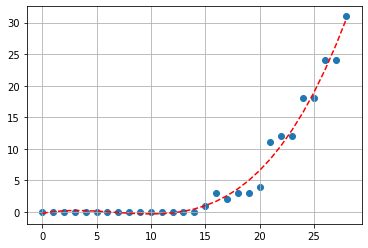

In [48]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

Total cases up to today: 1171
New cases registered today: 122
Doubling time in the last five days: 5.1
Trend of new cases (in %) in the last 5 days: 98.47


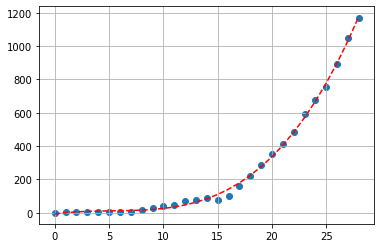

In [49]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

Total cases up to today: 93
New cases registered today: 11
Doubling time in the last five days: 4.0
Trend of new cases (in %) in the last 5 days: 138.46


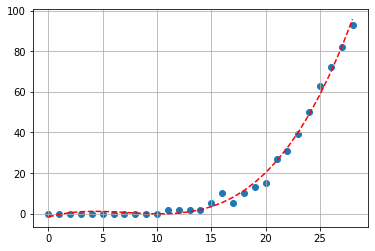

In [50]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

Total cases up to today: 1144
New cases registered today: 25
Doubling time in the last five days: 6.8
Trend of new cases (in %) in the last 5 days: 66.28


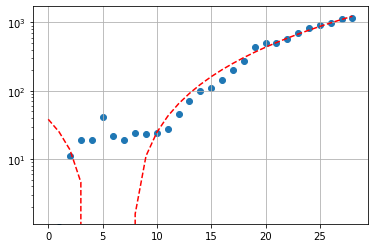

In [51]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

Total cases up to today: 689
New cases registered today: 12
Doubling time in the last five days: 5.8
Trend of new cases (in %) in the last 5 days: 82.28


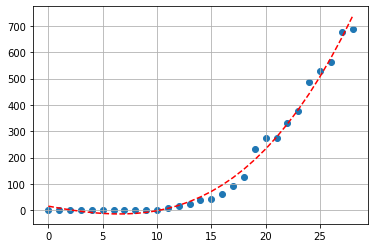

In [52]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

Total cases up to today: 160
New cases registered today: -8
Doubling time in the last five days: 7.5
Trend of new cases (in %) in the last 5 days: 58.42


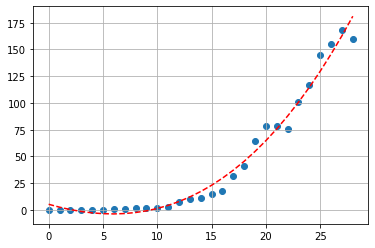

In [53]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

Total cases up to today: 110
New cases registered today: 11
Doubling time in the last five days: 12.3
Trend of new cases (in %) in the last 5 days: 32.53


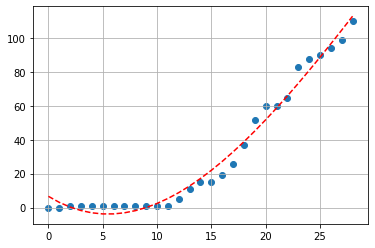

In [54]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

Total cases up to today: 185
New cases registered today: 10
Doubling time in the last five days: 9.0
Trend of new cases (in %) in the last 5 days: 46.83


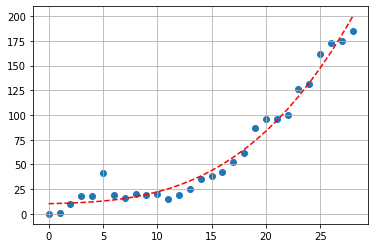

In [55]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

Total cases up to today: 28147
New cases registered today: 1557
Doubling time in the last five days: 7.1
Trend of new cases (in %) in the last 5 days: 62.42


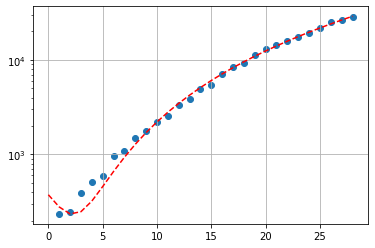

In [56]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

Total cases up to today: 6471
New cases registered today: 255
Doubling time in the last five days: 8.5
Trend of new cases (in %) in the last 5 days: 50.31


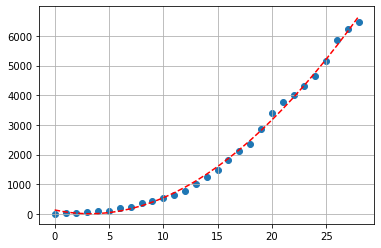

In [57]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

Total cases up to today: 5905
New cases registered today: 588
Doubling time in the last five days: 7.8
Trend of new cases (in %) in the last 5 days: 56.05


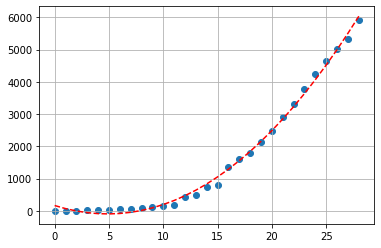

In [58]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

Total cases up to today: 581
New cases registered today: 69
Doubling time in the last five days: 4.9
Trend of new cases (in %) in the last 5 days: 103.15


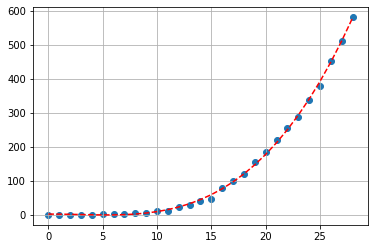

In [59]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

Total cases up to today: 2925
New cases registered today: 30
Doubling time in the last five days: 11.6
Trend of new cases (in %) in the last 5 days: 34.98


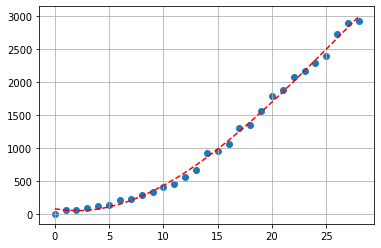

In [60]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

Total cases up to today: 934
New cases registered today: 62
Doubling time in the last five days: 5.0
Trend of new cases (in %) in the last 5 days: 100.43


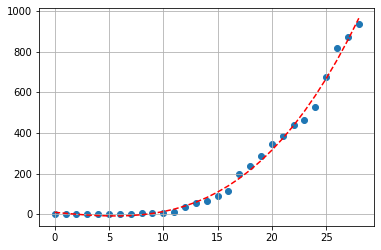

In [61]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

Total cases up to today: 1817
New cases registered today: 45
Doubling time in the last five days: 15.1
Trend of new cases (in %) in the last 5 days: 25.74


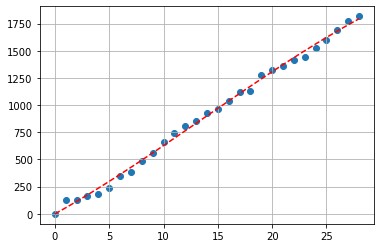

In [62]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

Total cases up to today: 985
New cases registered today: 80
Doubling time in the last five days: 5.3
Trend of new cases (in %) in the last 5 days: 91.63


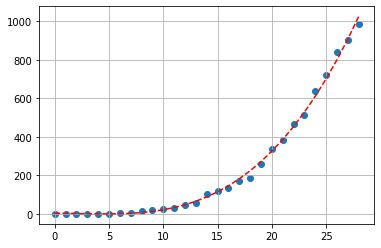

In [63]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

Total cases up to today: 5326
New cases registered today: 230
Doubling time in the last five days: 4.9
Trend of new cases (in %) in the last 5 days: 101.44


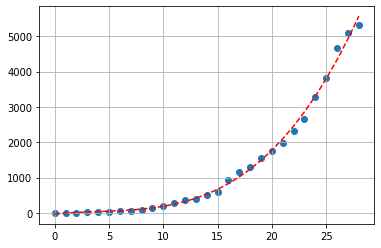

In [64]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

Total cases up to today: 1130
New cases registered today: 22
Doubling time in the last five days: 3.3
Trend of new cases (in %) in the last 5 days: 181.8


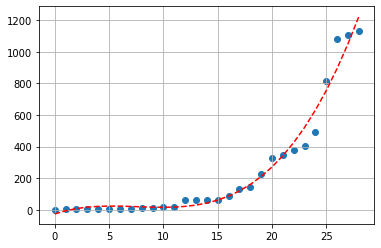

In [65]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

Total cases up to today: 1444
New cases registered today: 138
Doubling time in the last five days: 8.9
Trend of new cases (in %) in the last 5 days: 47.65


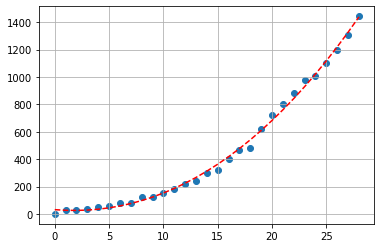

In [66]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

Total cases up to today: 208
New cases registered today: 3
Doubling time in the last five days: 3.4
Trend of new cases (in %) in the last 5 days: 177.33


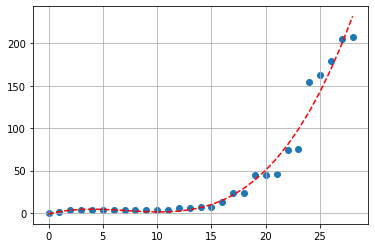

In [67]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

Total cases up to today: 421
New cases registered today: 35
Doubling time in the last five days: 7.5
Trend of new cases (in %) in the last 5 days: 58.87


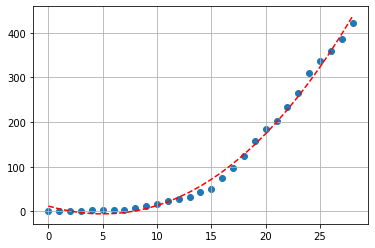

In [68]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 nelle Marche - COVID-19 cases in Marche

Total cases up to today: 2534
New cases registered today: 147
Doubling time in the last five days: 7.0
Trend of new cases (in %) in the last 5 days: 64.12


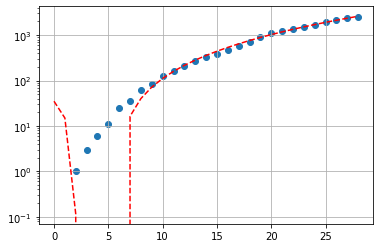

In [69]:
calculate_and_create_chart_for_region(START_DATE, 'Marche')

## Ancona

Total cases up to today: 702
New cases registered today: 26
Doubling time in the last five days: 6.2
Trend of new cases (in %) in the last 5 days: 74.19


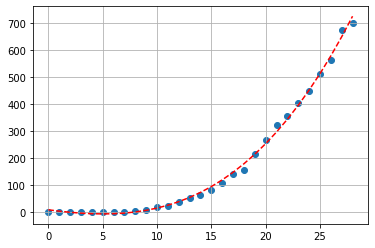

In [70]:
calculate_and_create_chart_for_province(START_DATE, 'Ancona')

## Ascoli Piceno

Total cases up to today: 61
New cases registered today: 5
Doubling time in the last five days: 3.9
Trend of new cases (in %) in the last 5 days: 144.0


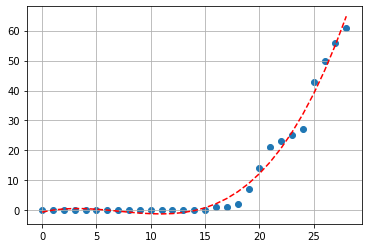

In [71]:
calculate_and_create_chart_for_province(START_DATE, 'Ascoli Piceno')

## Fermo

Total cases up to today: 133
New cases registered today: 20
Doubling time in the last five days: 3.3
Trend of new cases (in %) in the last 5 days: 189.13


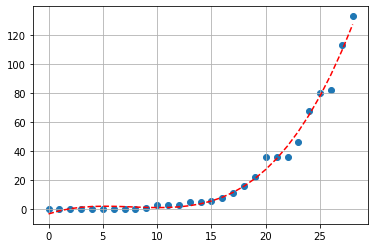

In [72]:
calculate_and_create_chart_for_province(START_DATE, 'Fermo')

## Macerata

Total cases up to today: 326
New cases registered today: 33
Doubling time in the last five days: 4.9
Trend of new cases (in %) in the last 5 days: 103.75


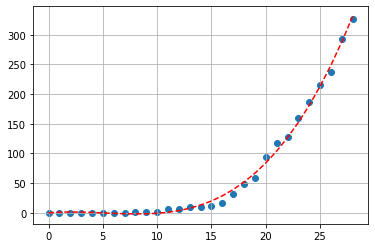

In [73]:
calculate_and_create_chart_for_province(START_DATE, 'Macerata')

## Pesaro e Urbino

Total cases up to today: 1312
New cases registered today: 63
Doubling time in the last five days: 9.5
Trend of new cases (in %) in the last 5 days: 44.18


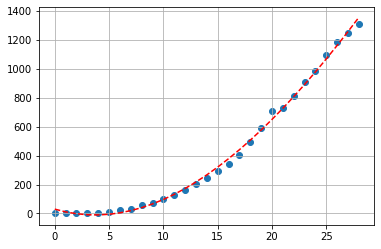

In [74]:
calculate_and_create_chart_for_province(START_DATE, 'Pesaro e Urbino')

# Casi di COVID-19 in Molise - COVID-19 cases in Molise¶

Total cases up to today: 58
New cases registered today: 1
Doubling time in the last five days: 4.1
Trend of new cases (in %) in the last 5 days: 132.0


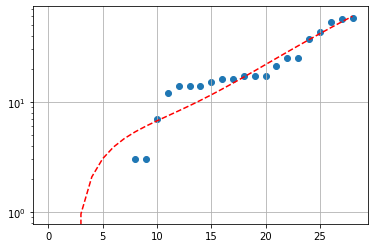

In [75]:
calculate_and_create_chart_for_region(START_DATE, 'Molise')

## Campobasso

Total cases up to today: 54
New cases registered today: 1
Doubling time in the last five days: 4.3
Trend of new cases (in %) in the last 5 days: 125.0


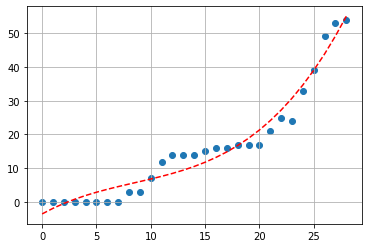

In [76]:
calculate_and_create_chart_for_province(START_DATE, 'Campobasso')

## Isernia

Total cases up to today: 4
New cases registered today: 0
Doubling time in the last five days: 2.5
Trend of new cases (in %) in the last 5 days: 300.0


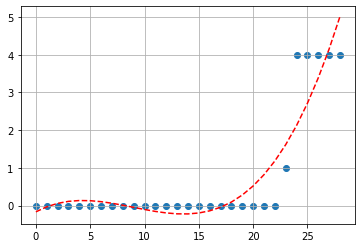

In [77]:
calculate_and_create_chart_for_province(START_DATE, 'Isernia')

# Casi di COVID-19 in Piemonte - COVID-19 cases in Piedmont 

Total cases up to today: 4717
New cases registered today: 442
Doubling time in the last five days: 4.5
Trend of new cases (in %) in the last 5 days: 115.88


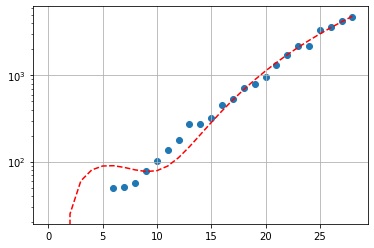

In [78]:
calculate_and_create_chart_for_region(START_DATE, 'Piemonte')

## Alessandria

Total cases up to today: 817
New cases registered today: 57
Doubling time in the last five days: 4.4
Trend of new cases (in %) in the last 5 days: 118.45


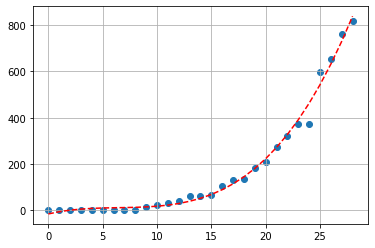

In [79]:
calculate_and_create_chart_for_province(START_DATE, 'Alessandria')

## Asti

Total cases up to today: 209
New cases registered today: 28
Doubling time in the last five days: 4.8
Trend of new cases (in %) in the last 5 days: 106.93


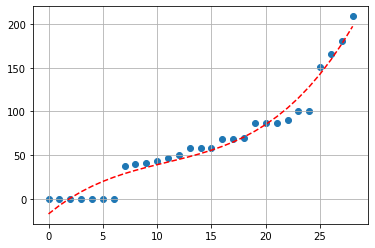

In [80]:
calculate_and_create_chart_for_province(START_DATE, 'Asti')

## Biella

Total cases up to today: 253
New cases registered today: 10
Doubling time in the last five days: 4.1
Trend of new cases (in %) in the last 5 days: 132.11


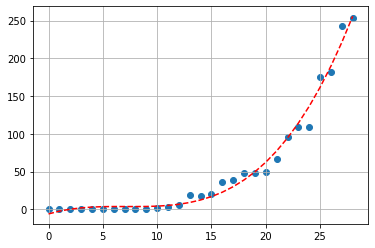

In [81]:
calculate_and_create_chart_for_province(START_DATE, 'Biella')

## Cuneo

Total cases up to today: 367
New cases registered today: 64
Doubling time in the last five days: 3.8
Trend of new cases (in %) in the last 5 days: 146.31


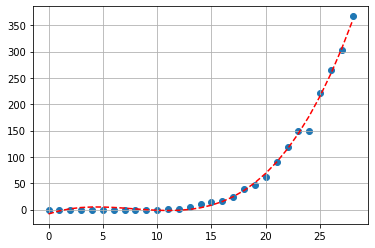

In [82]:
calculate_and_create_chart_for_province(START_DATE, 'Cuneo')

## Novara

Total cases up to today: 420
New cases registered today: 22
Doubling time in the last five days: 4.4
Trend of new cases (in %) in the last 5 days: 121.05


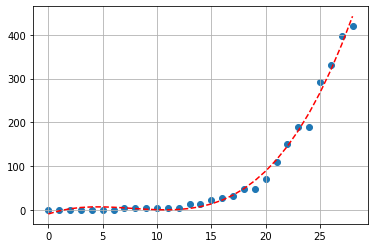

In [83]:
calculate_and_create_chart_for_province(START_DATE, 'Novara')

## Torino

Total cases up to today: 2198
New cases registered today: 209
Doubling time in the last five days: 4.6
Trend of new cases (in %) in the last 5 days: 110.94


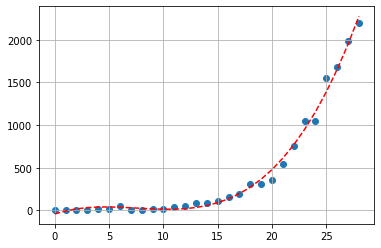

In [84]:
calculate_and_create_chart_for_province(START_DATE, 'Torino')

## 	Verbano-Cusio-Ossola

Total cases up to today: 190
New cases registered today: 31
Doubling time in the last five days: 4.6
Trend of new cases (in %) in the last 5 days: 113.48


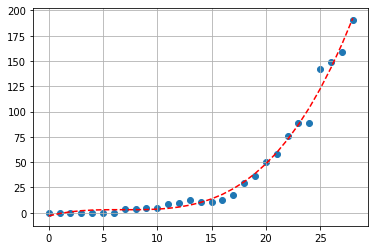

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Verbano-Cusio-Ossola')

## Vercelli

Total cases up to today: 263
New cases registered today: 21
Doubling time in the last five days: 5.0
Trend of new cases (in %) in the last 5 days: 100.76


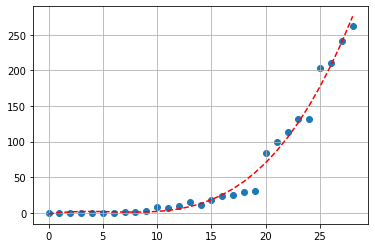

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Vercelli')

# Casi di COVID-19 in Puglia - COVID-19 cases in Apulia

Total cases up to today: 850
New cases registered today: 97
Doubling time in the last five days: 4.2
Trend of new cases (in %) in the last 5 days: 126.67


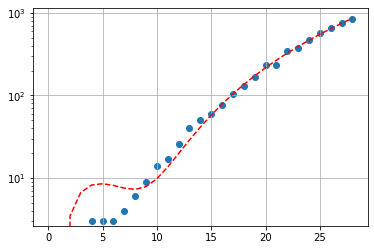

In [87]:
calculate_and_create_chart_for_region(START_DATE, 'Puglia')

## Bari

Total cases up to today: 268
New cases registered today: 37
Doubling time in the last five days: 4.0
Trend of new cases (in %) in the last 5 days: 139.29


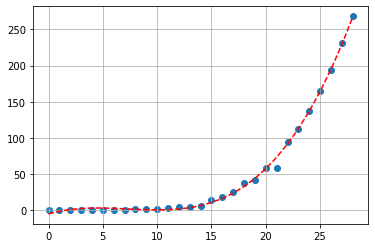

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Bari')

## 	Barletta-Andria-Trani

Total cases up to today: 59
New cases registered today: 10
Doubling time in the last five days: 3.7
Trend of new cases (in %) in the last 5 days: 156.52


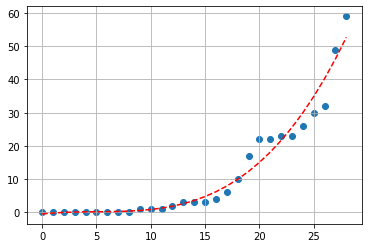

In [89]:
calculate_and_create_chart_for_province(START_DATE, 'Barletta-Andria-Trani')

## Brindisi

Total cases up to today: 102
New cases registered today: 2
Doubling time in the last five days: 7.7
Trend of new cases (in %) in the last 5 days: 56.92


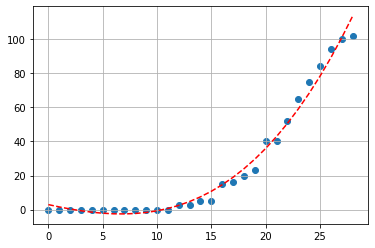

In [90]:
calculate_and_create_chart_for_province(START_DATE, 'Brindisi')

## Foggia

Total cases up to today: 226
New cases registered today: 14
Doubling time in the last five days: 3.8
Trend of new cases (in %) in the last 5 days: 148.35


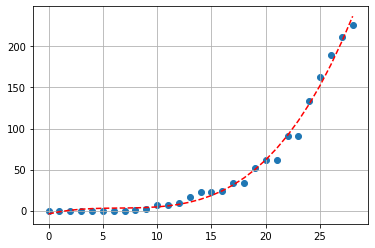

In [91]:
calculate_and_create_chart_for_province(START_DATE, 'Foggia')

## Lecce

Total cases up to today: 149
New cases registered today: 29
Doubling time in the last five days: 4.2
Trend of new cases (in %) in the last 5 days: 129.23


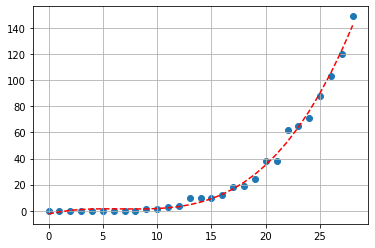

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Lecce')

## Taranto

Total cases up to today: 46
New cases registered today: 5
Doubling time in the last five days: 3.9
Trend of new cases (in %) in the last 5 days: 142.11


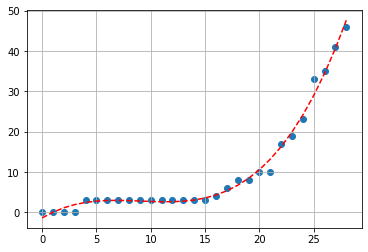

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Taranto')

# Casi di COVID-19 in Sardegna - COVID-19 cases in Sardinia

Total cases up to today: 359
New cases registered today: 20
Doubling time in the last five days: 3.5
Trend of new cases (in %) in the last 5 days: 167.91


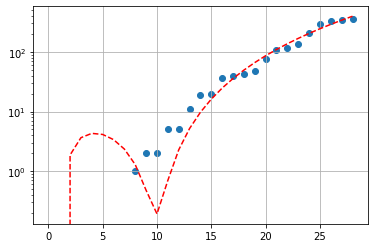

In [94]:
calculate_and_create_chart_for_region(START_DATE, 'Sardegna')

## Cagliari

Total cases up to today: 61
New cases registered today: 9
Doubling time in the last five days: 5.4
Trend of new cases (in %) in the last 5 days: 90.62


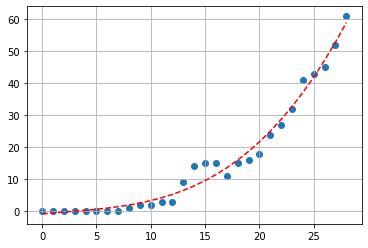

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Cagliari')

## Nuoro

Total cases up to today: 22
New cases registered today: 0
Doubling time in the last five days: 36.4
Trend of new cases (in %) in the last 5 days: 10.0


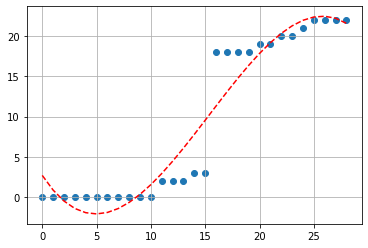

In [96]:
calculate_and_create_chart_for_province(START_DATE, 'Nuoro')

## Oristano

Total cases up to today: 7
New cases registered today: 3
Doubling time in the last five days: 4.1
Trend of new cases (in %) in the last 5 days: 133.33


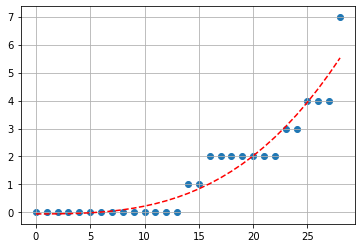

In [97]:
calculate_and_create_chart_for_province(START_DATE, 'Oristano')

## Sassari

Total cases up to today: 260
New cases registered today: 7
Doubling time in the last five days: 2.8
Trend of new cases (in %) in the last 5 days: 251.35


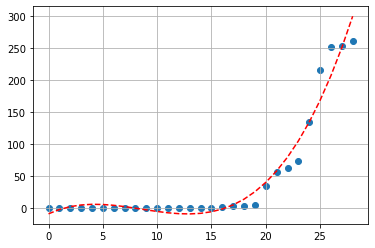

In [98]:
calculate_and_create_chart_for_province(START_DATE, 'Sassari')

# Casi di COVID-19 in Sicilia - COVID-19 cases in Sicily

Total cases up to today: 721
New cases registered today: 91
Doubling time in the last five days: 3.7
Trend of new cases (in %) in the last 5 days: 155.67


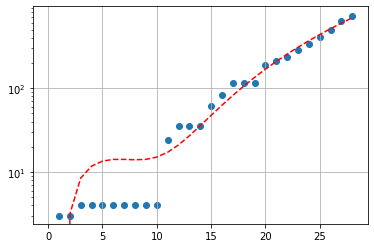

In [99]:
calculate_and_create_chart_for_region(START_DATE, 'Sicilia')

## Agrigento

Total cases up to today: 45
New cases registered today: 4
Doubling time in the last five days: 5.5
Trend of new cases (in %) in the last 5 days: 87.5


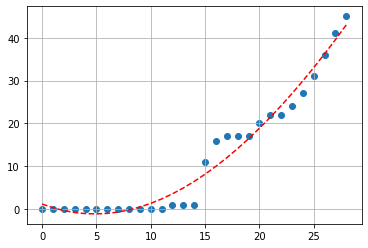

In [100]:
calculate_and_create_chart_for_province(START_DATE, 'Agrigento')

## Caltanissetta

Total cases up to today: 29
New cases registered today: 2
Doubling time in the last five days: 2.2
Trend of new cases (in %) in the last 5 days: 383.33


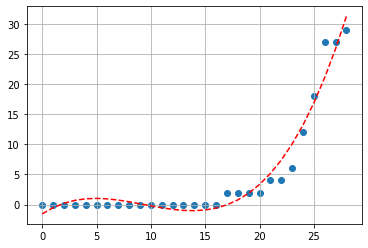

In [101]:
calculate_and_create_chart_for_province(START_DATE, 'Caltanissetta')

## Catania

Total cases up to today: 274
New cases registered today: 40
Doubling time in the last five days: 4.7
Trend of new cases (in %) in the last 5 days: 109.16


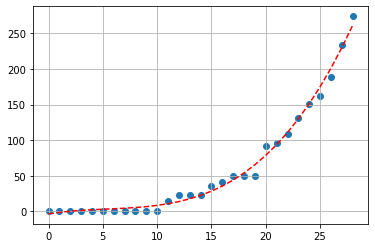

In [102]:
calculate_and_create_chart_for_province(START_DATE, 'Catania')

## Enna

Total cases up to today: 44
New cases registered today: 10
Doubling time in the last five days: 2.0
Trend of new cases (in %) in the last 5 days: 450.0


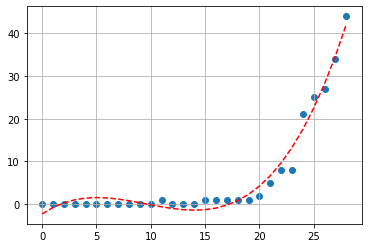

In [103]:
calculate_and_create_chart_for_province(START_DATE, 'Enna')

## Messina

Total cases up to today: 120
New cases registered today: 8
Doubling time in the last five days: 1.7
Trend of new cases (in %) in the last 5 days: 650.0


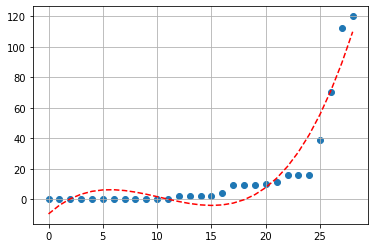

In [104]:
calculate_and_create_chart_for_province(START_DATE, 'Messina')

## Palermo

Total cases up to today: 109
New cases registered today: 17
Doubling time in the last five days: 4.1
Trend of new cases (in %) in the last 5 days: 131.91


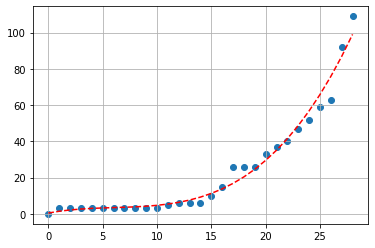

In [105]:
calculate_and_create_chart_for_province(START_DATE, 'Palermo')

## Ragusa

Total cases up to today: 9
New cases registered today: 0
Doubling time in the last five days: 8.5
Trend of new cases (in %) in the last 5 days: 50.0


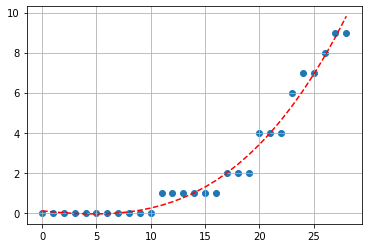

In [106]:
calculate_and_create_chart_for_province(START_DATE, 'Ragusa')

## Siracusa

Total cases up to today: 49
New cases registered today: 0
Doubling time in the last five days: 6.2
Trend of new cases (in %) in the last 5 days: 75.0


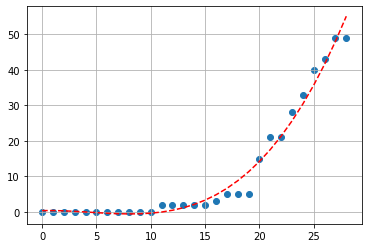

In [107]:
calculate_and_create_chart_for_province(START_DATE, 'Siracusa')

## Trapani

Total cases up to today: 42
New cases registered today: 10
Doubling time in the last five days: 3.6
Trend of new cases (in %) in the last 5 days: 162.5


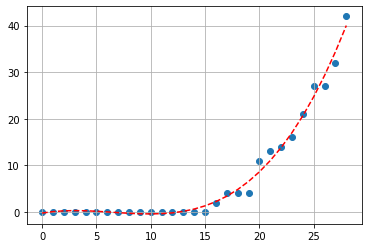

In [108]:
calculate_and_create_chart_for_province(START_DATE, 'Trapani')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

Total cases up to today: 2461
New cases registered today: 184
Doubling time in the last five days: 5.6
Trend of new cases (in %) in the last 5 days: 85.04


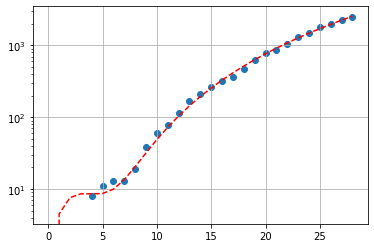

In [109]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

Total cases up to today: 201
New cases registered today: 47
Doubling time in the last five days: 10.0
Trend of new cases (in %) in the last 5 days: 41.55


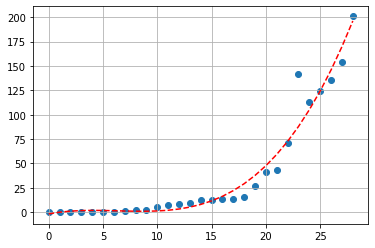

In [110]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

Total cases up to today: 548
New cases registered today: 34
Doubling time in the last five days: 5.6
Trend of new cases (in %) in the last 5 days: 85.76


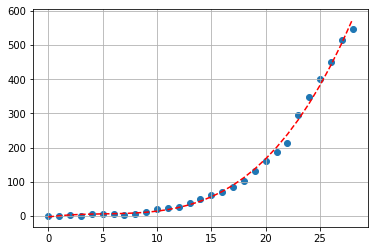

In [111]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

Total cases up to today: 128
New cases registered today: 8
Doubling time in the last five days: 5.5
Trend of new cases (in %) in the last 5 days: 88.24


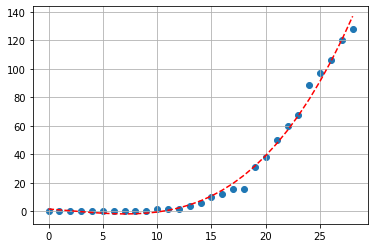

In [112]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

Total cases up to today: 140
New cases registered today: 10
Doubling time in the last five days: 4.3
Trend of new cases (in %) in the last 5 days: 125.81


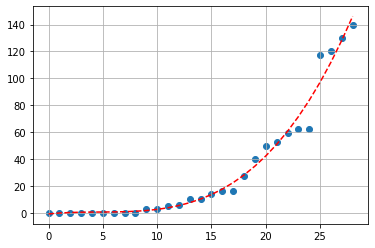

In [113]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

Total cases up to today: 363
New cases registered today: 7
Doubling time in the last five days: 6.1
Trend of new cases (in %) in the last 5 days: 77.07


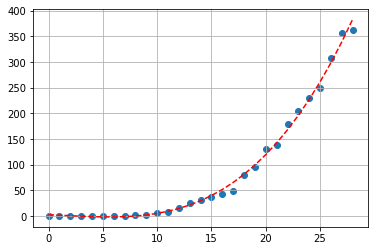

In [114]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

Total cases up to today: 289
New cases registered today: 8
Doubling time in the last five days: 7.0
Trend of new cases (in %) in the last 5 days: 64.2


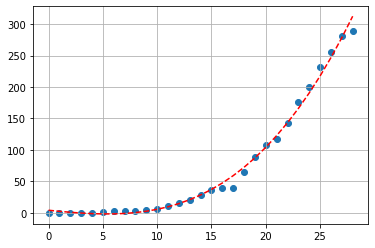

In [115]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

Total cases up to today: 266
New cases registered today: 32
Doubling time in the last five days: 4.5
Trend of new cases (in %) in the last 5 days: 114.52


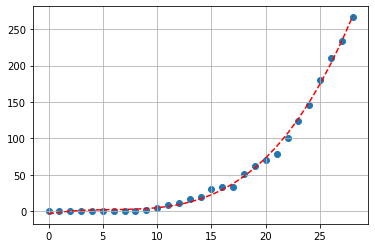

In [116]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

Total cases up to today: 229
New cases registered today: 14
Doubling time in the last five days: 5.5
Trend of new cases (in %) in the last 5 days: 87.7


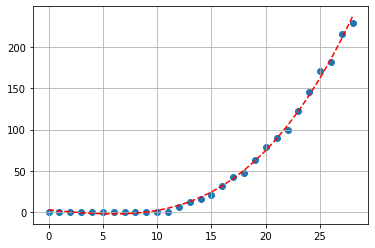

In [117]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

Total cases up to today: 137
New cases registered today: 8
Doubling time in the last five days: 4.1
Trend of new cases (in %) in the last 5 days: 132.2


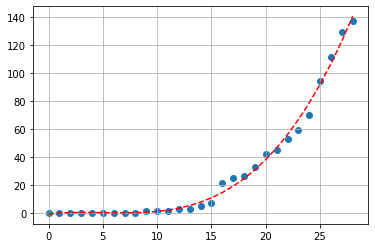

In [118]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

Total cases up to today: 160
New cases registered today: 16
Doubling time in the last five days: 4.7
Trend of new cases (in %) in the last 5 days: 107.79


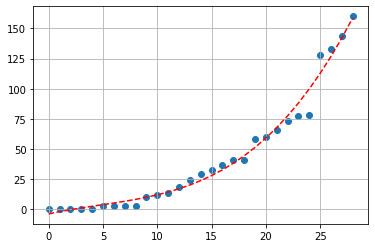

In [119]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi di COVID-19 in Provincia Autonoma di Trento - COVID-19 cases in the Autonomous Province of Trento

Total cases up to today: 1023
New cases registered today: 69
Doubling time in the last five days: 4.3
Trend of new cases (in %) in the last 5 days: 124.84


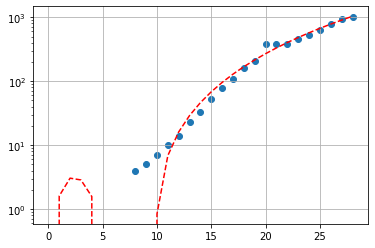

In [120]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Trento')

# Casi di COVID-19 in Umbria - COVID-19 cases in Umbria

Total cases up to today: 558
New cases registered today: 54
Doubling time in the last five days: 4.1
Trend of new cases (in %) in the last 5 days: 134.45


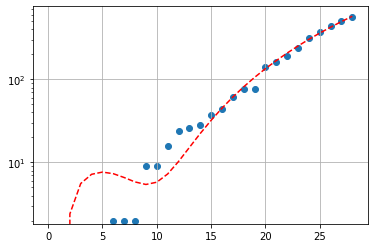

In [121]:
calculate_and_create_chart_for_region(START_DATE, 'Umbria')

## Perugia

Total cases up to today: 424
New cases registered today: 48
Doubling time in the last five days: 3.6
Trend of new cases (in %) in the last 5 days: 158.54


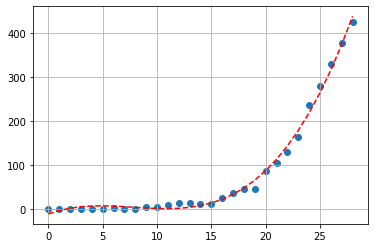

In [122]:
calculate_and_create_chart_for_province(START_DATE, 'Perugia')

## Terni

Total cases up to today: 134
New cases registered today: 6
Doubling time in the last five days: 5.8
Trend of new cases (in %) in the last 5 days: 81.08


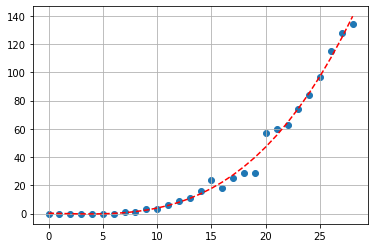

In [123]:
calculate_and_create_chart_for_province(START_DATE, 'Terni')

# Casi di COVID-19 in Valle d'Aosta - COVID-19 cases in Aosta Valley

Total cases up to today: 393
New cases registered today: 29
Doubling time in the last five days: 4.0
Trend of new cases (in %) in the last 5 days: 138.18


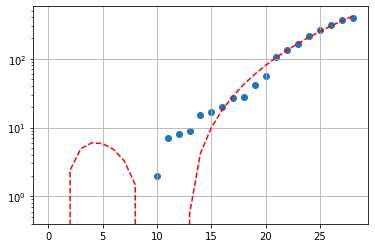

In [124]:
calculate_and_create_chart_for_region(START_DATE, "Valle d'Aosta")

# Casi di COVID-19 in Veneto - COVID-19 cases in Veneto

Total cases up to today: 5293
New cases registered today: 370
Doubling time in the last five days: 6.4
Trend of new cases (in %) in the last 5 days: 71.24


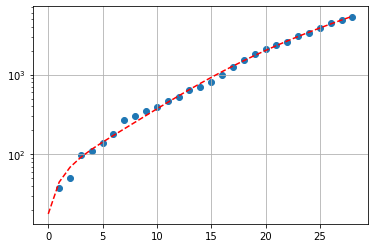

In [125]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Belluno

Total cases up to today: 254
New cases registered today: 28
Doubling time in the last five days: 5.8
Trend of new cases (in %) in the last 5 days: 81.43


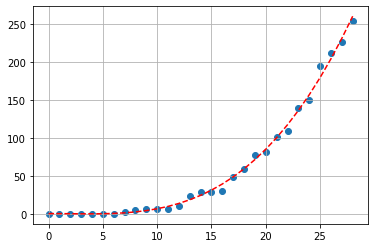

In [126]:
calculate_and_create_chart_for_province(START_DATE, 'Belluno')

## Padova

Total cases up to today: 1371
New cases registered today: 94
Doubling time in the last five days: 7.9
Trend of new cases (in %) in the last 5 days: 55.44


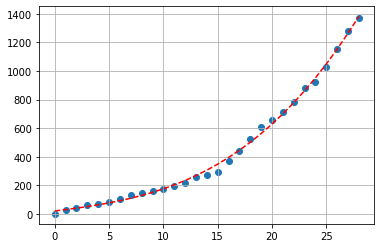

In [127]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')

## Rovigo

Total cases up to today: 80
New cases registered today: 4
Doubling time in the last five days: 3.9
Trend of new cases (in %) in the last 5 days: 142.42


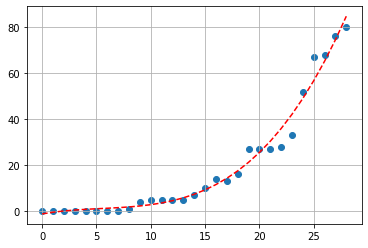

In [128]:
calculate_and_create_chart_for_province(START_DATE, 'Rovigo')

## Treviso

Total cases up to today: 999
New cases registered today: 64
Doubling time in the last five days: 6.6
Trend of new cases (in %) in the last 5 days: 69.04


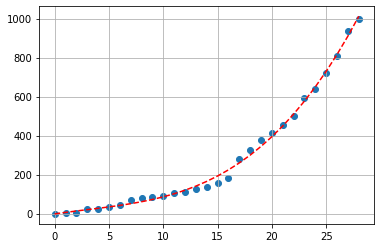

In [129]:
calculate_and_create_chart_for_province(START_DATE, 'Treviso')

## Venezia

Total cases up to today: 799
New cases registered today: 67
Doubling time in the last five days: 5.5
Trend of new cases (in %) in the last 5 days: 87.56


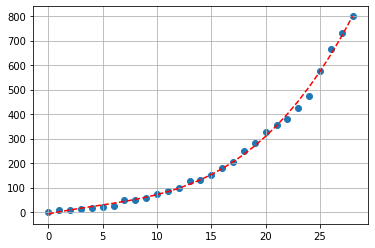

In [130]:
calculate_and_create_chart_for_province(START_DATE, 'Venezia')

## Verona

Total cases up to today: 1099
New cases registered today: 53
Doubling time in the last five days: 6.2
Trend of new cases (in %) in the last 5 days: 75.56


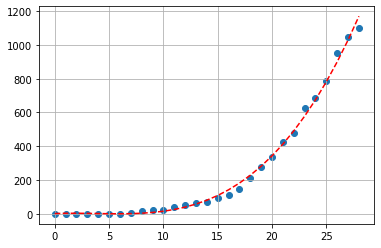

In [131]:
calculate_and_create_chart_for_province(START_DATE, 'Verona')

## Vicenza

Total cases up to today: 691
New cases registered today: 60
Doubling time in the last five days: 6.1
Trend of new cases (in %) in the last 5 days: 75.83


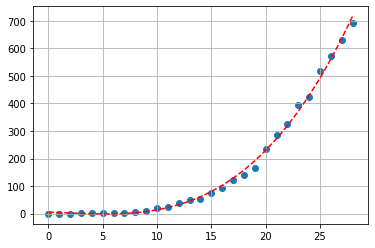

In [132]:
calculate_and_create_chart_for_province(START_DATE, 'Vicenza')